In [2]:
import scipy.io
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
from numpy import genfromtxt
from aux_functions2 import xavier_init
from aux_functions2 import plot #MINE

import csv
import sys

In [3]:
steps = 40000 # int(sys.argv[1])  # number of training steps
iteration = 5 # int(sys.argv[2])  # number of iterations (iid runs)
d = 4 # int(sys.argv[3])  # dimension of the distributions
mb_size = 4000 # int(sys.argv[4])  # batch size
N = 50000
rho_range = [0.1, 0.3, 0.5, 0.7, 0.9]
print(steps)
print(iteration)
print(d)
print(mb_size)
print(N)


40000
5
4
4000
50000


In [4]:
# hyperparameters
if d==4:
    layers = [d, 8, 8, 4, 1]
elif d==20:
    layers = [d, 32, 32, 16, 1]
elif d==50:
    layers = [d, 32, 32, 16, 1] # [d, 64, 64, 32, 1]
else:                      
    print('check dimension!')

lam = 1.0 # lambda=beta+gamma

# initialize
X = tf.placeholder(tf.float32, shape=[None, d])
Y = tf.placeholder(tf.float32, shape=[None, d])

def initialize_NN(layers):
    NN_W = []
    NN_b = []
    num_layers = len(layers)
    for l in range(0,num_layers-1):
        W = tf.Variable(xavier_init(size=[layers[l], layers[l+1]]), name="W")
        b = tf.Variable(tf.zeros([1,layers[l+1]], dtype=tf.float32), dtype=tf.float32)
        NN_W.append(W)
        NN_b.append(b)
    return NN_W, NN_b

D_W, D_b = initialize_NN(layers)

theta_D = [D_W, D_b] 


In [5]:
def discriminator(x):
    num_layers = len(D_W) + 1
    
    h = x  
    for l in range(0,num_layers-2):
        W = D_W[l]
        b = D_b[l]
        h = tf.tanh(tf.add(tf.matmul(h, W), b))
    
    W = D_W[-1]
    b = D_b[-1]
    out = 50.0 * tf.nn.tanh(tf.add(tf.matmul(h, W), b) / 50.0) # bound M = 50
    #out = 20.0 * tf.nn.tanh(tf.add(tf.matmul(h, W), b) / 20.0)

    return out

D_real = discriminator(X)
D_fake = discriminator(Y)


In [6]:
config = tf.ConfigProto(device_count={'GPU': 0})
sess = tf.Session(config=config)
sess.run(tf.global_variables_initializer())

SF = 1000
D_loss_vals =  np.zeros(shape=(len(rho_range), iteration))
RD_exact_rho =  np.zeros(shape= len(rho_range))


In [7]:

# estimate Renyi divergence

# Loop over #samples, then over iid iterations and then over training steps
for j, rho in enumerate(rho_range): 
    
    print('j=', j)
    print('rho=', rho)
    
    # load data
    #fname = 'data/mu2_1_arch_16/N'+str(n)+'_a_0.5_and_3.7/input_data/GMM_d_1_'
    fname = 'data/varying_rho_Sigma1_eye_2/d_4/input_N50000_dim4/gaussian_d_' + str(d) + '_'
    data = scipy.io.loadmat(fname + 'data_'+str(rho)+'.mat')
    x_ = np.array(data['x'])
    y_ = np.array(data['y'])

    params = scipy.io.loadmat(fname + 'params_'+str(rho)+'.mat')
    alpha = np.array(params['alpha'])
    No_alpha = alpha.shape[0]

    RD_exact = np.array(params['RD_exact']) # contains exact for all alphas. In current datafiles, only one

    
    beta = lam*(1-alpha[0])  #   <----------- choose the first alpha value
    gamma = lam*alpha[0]  #  <---------- choose the first alpha value
    
    #exact value for Renyi (estimated by integral computation)
    RD_exact_rho[j] = RD_exact[0];
    
    # variational representation:
    if beta == 0:
        D_loss_real = -tf.reduce_mean(D_real)
    else:
        max_val = tf.reduce_max((-beta) * D_real)
        D_loss_real = (1.0 / beta) * (tf.log(tf.reduce_mean(tf.exp((-beta) * D_real - max_val))) + max_val)

    if gamma == 0:
        D_loss_fake = tf.reduce_mean(D_fake)

    else:
        max_val = tf.reduce_max((gamma) * D_fake)
        D_loss_fake = (1.0 / gamma) * (tf.log(tf.reduce_mean(tf.exp(gamma * D_fake - max_val))) + max_val)

    D_loss = D_loss_real + D_loss_fake
    total_loss = D_loss

    #D_solver = tf.train.AdamOptimizer().minimize(total_loss, var_list=theta_D)
    D_solver = tf.train.AdamOptimizer(learning_rate=0.0005).minimize(total_loss, var_list=theta_D)

    for iter in range(iteration):
        print('Iteration: {}'.format(iter))
        sess.run(tf.global_variables_initializer())

        x = x_[np.random.randint(x_.shape[0], size=int(0.8*x_.shape[0])), :]
        y = y_[np.random.randint(y_.shape[0], size=int(0.8*x_.shape[0])), :]

        # initialize for plotting
        i = 0
        Pl_freq = 10
        D_loss_plot = np.zeros(shape=((np.rint(steps / Pl_freq)).astype(int), 1))  # because we writeout every Pl_freq

        for it in range(steps):
            X_mb = x[np.random.randint(x.shape[0], size=mb_size), :]
            Y_mb = y[np.random.randint(y.shape[0], size=mb_size), :]

            _, D_loss_curr, D_tot_loss = sess.run([D_solver, D_loss, total_loss], feed_dict={X: X_mb, Y: Y_mb})

            if it % Pl_freq == 0:
                D_loss_plot[i] = D_loss_curr
                i += 1

            if it % SF == 0:
                print('Iter: {}'.format(it))
                print('Renyi divergence: {}'.format(-lam*D_loss_curr))
                print()


        D_loss_curr = sess.run(D_loss, feed_dict={X: x, Y: y})
        D_loss_vals[j,iter] = -lam * D_loss_curr

 
    # -----------------------------------------------------------------------------
    # Plotting
    # -----------------------------------------------------------------------------
    if not os.path.exists('data/out_gaussian_BS_plots/'):
        os.makedirs('data/out_gaussian_BS_plots/')

    fig = plt.figure()
    #plt.plot(D_loss_plot)
    x_idx = np.linspace(0, steps, num=(np.rint(steps / Pl_freq)).astype(int))
    plt.plot(x_idx, D_loss_plot)
    plt.xlabel('steps')
    plt.ylabel('D loss')
    plt.savefig('data/out_gaussian_BS_plots/cgan_Dloss' + str(j) + 'rho_' + str(rho) +'.png', bbox_inches='tight')
    plt.close(fig)
   


j= 0
rho= 0.1
Iteration: 0
Iter: 0
Renyi divergence: [-2.0236475e-05]

Iter: 1000
Renyi divergence: [0.00605717]

Iter: 2000
Renyi divergence: [0.00577715]

Iter: 3000
Renyi divergence: [0.00781152]

Iter: 4000
Renyi divergence: [0.00685412]

Iter: 5000
Renyi divergence: [0.01233867]

Iter: 6000
Renyi divergence: [0.01015681]

Iter: 7000
Renyi divergence: [0.00989869]

Iter: 8000
Renyi divergence: [0.00333196]

Iter: 9000
Renyi divergence: [0.00967136]

Iter: 10000
Renyi divergence: [0.01117095]

Iter: 11000
Renyi divergence: [0.01601708]

Iter: 12000
Renyi divergence: [0.01555091]

Iter: 13000
Renyi divergence: [0.00764221]

Iter: 14000
Renyi divergence: [0.01134211]

Iter: 15000
Renyi divergence: [0.01167208]

Iter: 16000
Renyi divergence: [0.0115931]

Iter: 17000
Renyi divergence: [0.01217431]

Iter: 18000
Renyi divergence: [0.01445127]

Iter: 19000
Renyi divergence: [0.01940483]

Iter: 20000
Renyi divergence: [0.01144195]

Iter: 21000
Renyi divergence: [0.01315993]

Iter: 22000
Ren

Iter: 26000
Renyi divergence: [0.00982636]

Iter: 27000
Renyi divergence: [0.01721394]

Iter: 28000
Renyi divergence: [0.01007414]

Iter: 29000
Renyi divergence: [0.01574796]

Iter: 30000
Renyi divergence: [0.018085]

Iter: 31000
Renyi divergence: [0.01100475]

Iter: 32000
Renyi divergence: [0.00921065]

Iter: 33000
Renyi divergence: [0.01582068]

Iter: 34000
Renyi divergence: [0.011962]

Iter: 35000
Renyi divergence: [0.01173466]

Iter: 36000
Renyi divergence: [0.01422489]

Iter: 37000
Renyi divergence: [0.01741129]

Iter: 38000
Renyi divergence: [0.01235753]

Iter: 39000
Renyi divergence: [0.01317048]

j= 1
rho= 0.3
Iteration: 0
Iter: 0
Renyi divergence: [1.4717516e-06]

Iter: 1000
Renyi divergence: [0.00967848]

Iter: 2000
Renyi divergence: [0.04073727]

Iter: 3000
Renyi divergence: [0.10394692]

Iter: 4000
Renyi divergence: [0.10578465]

Iter: 5000
Renyi divergence: [0.09108531]

Iter: 6000
Renyi divergence: [0.10621357]

Iter: 7000
Renyi divergence: [0.09423184]

Iter: 8000
Renyi 

Iter: 12000
Renyi divergence: [0.10992408]

Iter: 13000
Renyi divergence: [0.09937227]

Iter: 14000
Renyi divergence: [0.09968913]

Iter: 15000
Renyi divergence: [0.10254824]

Iter: 16000
Renyi divergence: [0.11307621]

Iter: 17000
Renyi divergence: [0.12363553]

Iter: 18000
Renyi divergence: [0.098997]

Iter: 19000
Renyi divergence: [0.08751714]

Iter: 20000
Renyi divergence: [0.10518432]

Iter: 21000
Renyi divergence: [0.11375213]

Iter: 22000
Renyi divergence: [0.10523593]

Iter: 23000
Renyi divergence: [0.11297512]

Iter: 24000
Renyi divergence: [0.10666418]

Iter: 25000
Renyi divergence: [0.1180712]

Iter: 26000
Renyi divergence: [0.10870409]

Iter: 27000
Renyi divergence: [0.10890794]

Iter: 28000
Renyi divergence: [0.11339056]

Iter: 29000
Renyi divergence: [0.10343528]

Iter: 30000
Renyi divergence: [0.1121254]

Iter: 31000
Renyi divergence: [0.12118077]

Iter: 32000
Renyi divergence: [0.09779024]

Iter: 33000
Renyi divergence: [0.0917021]

Iter: 34000
Renyi divergence: [0.1094

Iter: 39000
Renyi divergence: [0.35470366]

Iteration: 4
Iter: 0
Renyi divergence: [2.2859313e-05]

Iter: 1000
Renyi divergence: [0.24577868]

Iter: 2000
Renyi divergence: [0.35885608]

Iter: 3000
Renyi divergence: [0.3074844]

Iter: 4000
Renyi divergence: [0.34518147]

Iter: 5000
Renyi divergence: [0.31890512]

Iter: 6000
Renyi divergence: [0.33026385]

Iter: 7000
Renyi divergence: [0.3159995]

Iter: 8000
Renyi divergence: [0.32941556]

Iter: 9000
Renyi divergence: [0.32986236]

Iter: 10000
Renyi divergence: [0.36262727]

Iter: 11000
Renyi divergence: [0.33057213]

Iter: 12000
Renyi divergence: [0.3517728]

Iter: 13000
Renyi divergence: [0.34832883]

Iter: 14000
Renyi divergence: [0.31296825]

Iter: 15000
Renyi divergence: [0.31680012]

Iter: 16000
Renyi divergence: [0.33147383]

Iter: 17000
Renyi divergence: [0.35090995]

Iter: 18000
Renyi divergence: [0.34091902]

Iter: 19000
Renyi divergence: [0.31036234]

Iter: 20000
Renyi divergence: [0.35922217]

Iter: 21000
Renyi divergence: [0

Iter: 27000
Renyi divergence: [0.8541801]

Iter: 28000
Renyi divergence: [0.8427856]

Iter: 29000
Renyi divergence: [0.8501892]

Iter: 30000
Renyi divergence: [0.8128829]

Iter: 31000
Renyi divergence: [0.78654814]

Iter: 32000
Renyi divergence: [0.8671603]

Iter: 33000
Renyi divergence: [0.82988214]

Iter: 34000
Renyi divergence: [0.8195412]

Iter: 35000
Renyi divergence: [0.822711]

Iter: 36000
Renyi divergence: [0.8048248]

Iter: 37000
Renyi divergence: [0.819443]

Iter: 38000
Renyi divergence: [0.8239212]

Iter: 39000
Renyi divergence: [0.84402466]

Iteration: 4
Iter: 0
Renyi divergence: [-3.953988e-06]

Iter: 1000
Renyi divergence: [0.81355166]

Iter: 2000
Renyi divergence: [0.81450987]

Iter: 3000
Renyi divergence: [0.79821515]

Iter: 4000
Renyi divergence: [0.8666012]

Iter: 5000
Renyi divergence: [0.7709274]

Iter: 6000
Renyi divergence: [0.81212926]

Iter: 7000
Renyi divergence: [0.7883456]

Iter: 8000
Renyi divergence: [0.882607]

Iter: 9000
Renyi divergence: [0.8220687]

Ite

Iter: 17000
Renyi divergence: [2.3971877]

Iter: 18000
Renyi divergence: [2.3971791]

Iter: 19000
Renyi divergence: [2.4440851]

Iter: 20000
Renyi divergence: [2.4256802]

Iter: 21000
Renyi divergence: [2.5066428]

Iter: 22000
Renyi divergence: [2.4210372]

Iter: 23000
Renyi divergence: [2.4851265]

Iter: 24000
Renyi divergence: [2.4935408]

Iter: 25000
Renyi divergence: [2.4461088]

Iter: 26000
Renyi divergence: [2.4441628]

Iter: 27000
Renyi divergence: [2.541419]

Iter: 28000
Renyi divergence: [2.358827]

Iter: 29000
Renyi divergence: [2.5036974]

Iter: 30000
Renyi divergence: [2.4254465]

Iter: 31000
Renyi divergence: [2.5927086]

Iter: 32000
Renyi divergence: [2.475864]

Iter: 33000
Renyi divergence: [2.416944]

Iter: 34000
Renyi divergence: [2.5366836]

Iter: 35000
Renyi divergence: [2.4637604]

Iter: 36000
Renyi divergence: [2.5170765]

Iter: 37000
Renyi divergence: [2.4619417]

Iter: 38000
Renyi divergence: [2.4238453]

Iter: 39000
Renyi divergence: [2.489676]

Iteration: 4
Ite

In [8]:
print(D_loss_vals)

[[0.01556182 0.01334429 0.0109601  0.01309288 0.01388031]
 [0.10099101 0.10788488 0.10408068 0.10622406 0.10739183]
 [0.32559943 0.33027983 0.3218956  0.33873796 0.3372767 ]
 [0.82452869 0.81866693 0.81577349 0.82588768 0.83401322]
 [2.42230558 2.46730566 2.41635799 2.44464207 2.42788029]]


In [9]:
   

with open(fname+'lambda_'+str(lam)+'_bs_'+str(mb_size)+'_nerd_'+str(rho)+'.csv', "w") as output:
    writer = csv.writer(output, lineterminator='\n')
    for val in D_loss_vals:
        writer.writerow(val)


Text(0, 0.5, 'divergence')

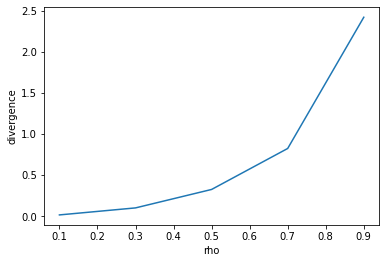

In [10]:
# Plot RD vs rho
#======================
fig = plt.figure()
plt.plot(rho_range, D_loss_vals[:,0])
plt.xlabel('rho')
plt.ylabel('divergence')

(0.0, 3.0)

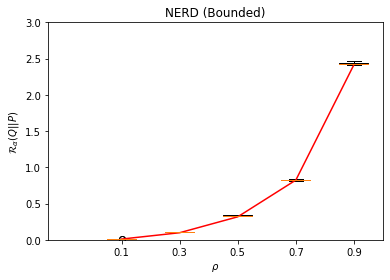

In [11]:


fig1, ax1 = plt.subplots()
ax1.set_title('NERD (Bounded)')
ax1.boxplot(np.transpose(D_loss_vals[:,:]) , labels=[0.1, 0.3, 0.5, 0.7, 0.9], whis=2)
ax1.plot(np.arange(1,len(rho_range)+1), RD_exact_rho[:],'r', 'LineWidth', 2 );
plt.xlabel(r'$\rho$')
plt.ylabel(r'$\mathcal{R}_{\alpha}(Q||P)$')
plt.ylim(0.0, 3.0)




In [ ]:
print('program terminated succesfully')